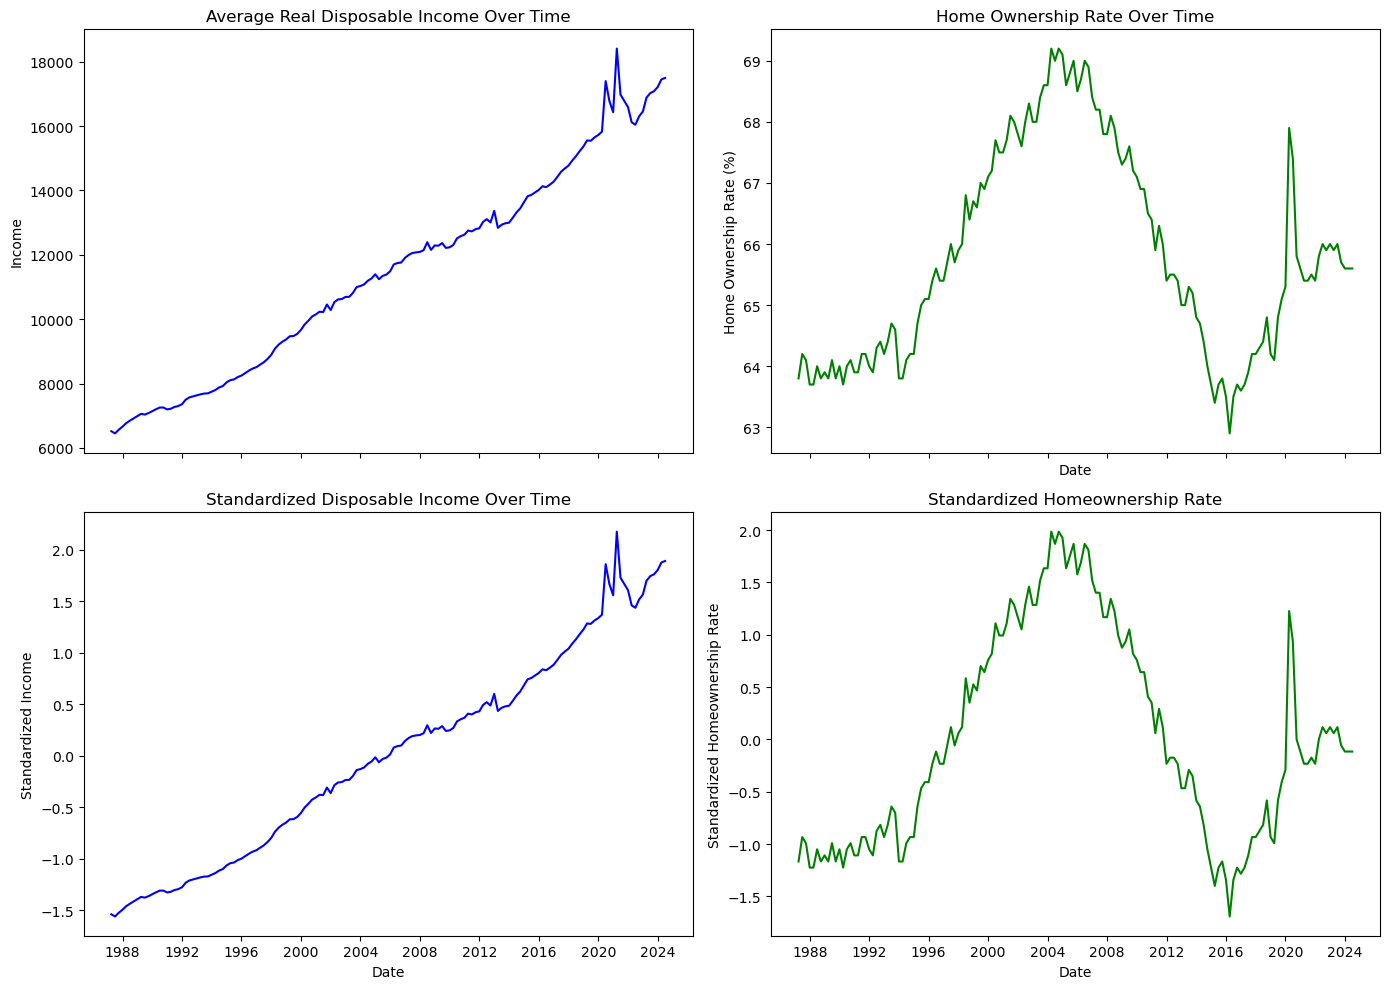

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
income_df = pd.read_csv('DSPIC96.csv', parse_dates=['DATE'])
home_ownership_df = pd.read_csv('RHORUSQ156N.csv', parse_dates=['DATE'])
home_price_index_df = pd.read_csv("CSUSHPINSA.csv", parse_dates=['DATE'])

# Resample income to quarterly if needed
income_df.set_index('DATE', inplace=True)
home_ownership_df.set_index('DATE', inplace=True)
home_price_index_df.set_index('DATE', inplace=True)

# Resample monthly data to quarterly using mean or forward fill methods
income_quarterly = income_df.resample('Q').mean()  # or use .ffill() for forward filling if preferable
home_price_index_quarterly = home_price_index_df.resample('Q').mean()

# Merge the datasets on the 'Date' index
income_quarterly.index = income_quarterly.index + pd.DateOffset(days=1)
home_price_index_quarterly.index = home_price_index_quarterly.index + pd.DateOffset(days=1)
merged_data = pd.merge(income_quarterly, home_ownership_df, on='DATE', how='inner')
merged_data = pd.merge(merged_data, home_price_index_quarterly, on='DATE', how='inner')

merged_data['Income_std'] = (merged_data['DSPIC96'] - merged_data['DSPIC96'].mean()) / merged_data['DSPIC96'].std()
merged_data['HomeOwnershipRate_std'] = (merged_data['RHORUSQ156N'] - merged_data['RHORUSQ156N'].mean()) / merged_data['RHORUSQ156N'].std()
merged_data['HPIndex_std'] = (merged_data['CSUSHPINSA'] - merged_data['CSUSHPINSA'].mean()) / merged_data['CSUSHPINSA'].std()

# Plotting in separate subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

# Plot Disposable Income
axs[0,0].plot(merged_data['DSPIC96'], color='blue')
axs[0,0].set_title("Average Real Disposable Income Over Time")
axs[0,0].set_ylabel("Income")

# Plot Home Ownership Rate
axs[0,1].plot(merged_data['RHORUSQ156N'], color='green')
axs[0,1].set_title("Home Ownership Rate Over Time")
axs[0,1].set_ylabel("Home Ownership Rate (%)")
axs[0,1].set_xlabel("Date")

axs[1,0].plot(merged_data['Income_std'], label="Standardized Disposable Income", color='blue')
axs[1,0].set_title("Standardized Disposable Income Over Time")
axs[1,0].set_ylabel("Standardized Income")
axs[1,0].set_xlabel("Date")

axs[1,1].plot(merged_data['HomeOwnershipRate_std'], label="Standardized Home Ownership Rate", color='green')
axs[1,1].set_title("Standardized Homeownership Rate")
axs[1,1].set_ylabel("Standardized Homeownership Rate")
axs[1,1].set_xlabel("Date")


plt.tight_layout()
plt.show()


In [57]:
merged_data

,DSPIC96,RHORUSQ156N,CSUSHPINSA,Income_std,HomeOwnershipRate_std,HPIndex_std
DATE,,,,,,
1987-04-01,6516.566667,63.8,64.111333,-1.537336,-1.166714,-1.240872
1987-07-01,6448.966667,64.2,65.577667,-1.558439,-0.933294,-1.218492
1987-10-01,6565.033333,64.1,67.225667,-1.522205,-0.991649,-1.193339
1988-01-01,6659.733333,63.7,68.111333,-1.492641,-1.225069,-1.179821
1988-04-01,6769.333333,63.7,68.939000,-1.458426,-1.225069,-1.167189
...,...,...,...,...,...,...
2023-07-01,17025.166667,66.0,305.245667,1.743294,0.117099,2.439503
2023-10-01,17082.833333,65.7,311.611333,1.761296,-0.057966,2.536660
2024-01-01,17216.533333,65.6,312.091667,1.803035,-0.116321,2.543992


In [65]:
from statsmodels.tsa.stattools import adfuller, grangercausalitytests

def adf_test(series, name):
    result = adfuller(series)
    print(f'ADF Test for {name}:')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] > 0.05:
        print(f"{name} is non-stationary. Consider differencing.\n")
    else:
        print(f"{name} is stationary.\n")

# Perform ADF test
adf_test(merged_data['Income_std'], 'Personal Income')
adf_test(merged_data['HomeOwnershipRate_std'], 'Home Ownership Rate')

# Difference if needed
merged_data['Income_diff'] = merged_data['Income_std'].diff().dropna()
merged_data['HomeOwnershipRate_diff'] = merged_data['HomeOwnershipRate_std'].diff().dropna()

adf_test(merged_data['Income_diff'].dropna(), 'Personal Income')
adf_test(merged_data['HomeOwnershipRate_diff'].dropna(), 'Home Ownership Rate')

# Run Granger causality test (after differencing if needed)
# Select maximum number of lags based on quarterly data, usually between 1-4 quarters
max_lags = 4
granger_test_results = grangercausalitytests(merged_data[['HomeOwnershipRate_diff', 'Income_diff']].dropna(), max_lags, verbose=True)

ADF Test for Personal Income:
ADF Statistic: 0.4464186647997833
p-value: 0.9831502582245389
Personal Income is non-stationary. Consider differencing.

ADF Test for Home Ownership Rate:
ADF Statistic: -2.566505163493037
p-value: 0.10011943755797181
Home Ownership Rate is non-stationary. Consider differencing.

ADF Test for Personal Income:
ADF Statistic: -6.960330406325488
p-value: 9.199769814200849e-10
Personal Income is stationary.

ADF Test for Home Ownership Rate:
ADF Statistic: -3.2888565304981388
p-value: 0.015383995653133586
Home Ownership Rate is stationary.


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1515  , p=0.0780  , df_denom=144, df_num=1
ssr based chi2 test:   chi2=3.2171  , p=0.0729  , df=1
likelihood ratio test: chi2=3.1824  , p=0.0744  , df=1
parameter F test:         F=3.1515  , p=0.0780  , df_denom=144, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4336  , p=0.6490  , df_denom=141, df_num=2
ssr ba

/Users/kevkoppa/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


income_df

ADF Statistic: -4.272004275846085
p-value: 0.0004965000280251131
Residuals are stationary (reject null hypothesis).


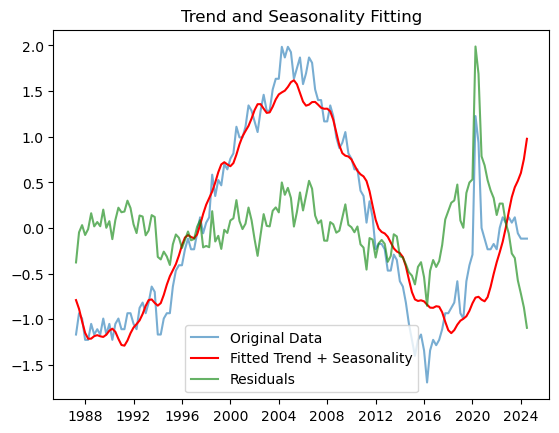

ADF Statistic: -3.5440055697840678
p-value: 0.006926299525032043
Residuals are stationary (reject null hypothesis).


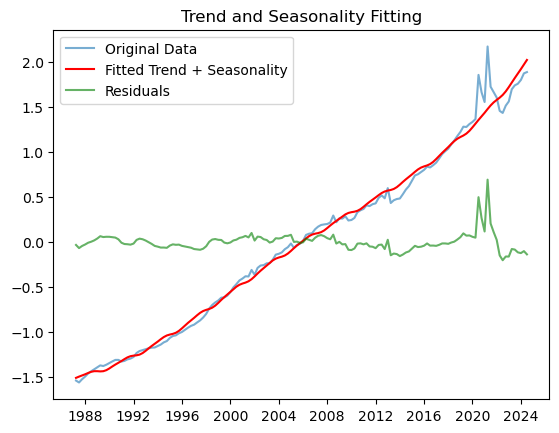

ADF Statistic: -3.4180756525376905
p-value: 0.010357892736026346
Residuals are stationary (reject null hypothesis).


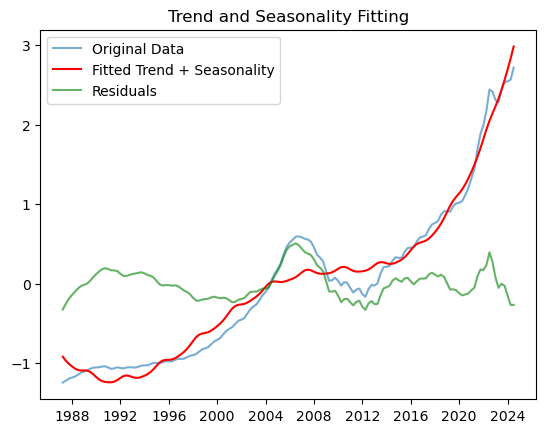

In [58]:
import numpy as np
import pandas as pd
from patsy import dmatrix
from statsmodels.tsa.statespace.tools import diff
from statsmodels.api import OLS
from scipy.stats import zscore
from statsmodels.tsa.stattools import adfuller


def make_stationary(series):
    data = series['data']
    # Step 1: Create a spline basis for trend
    time = np.arange(len(data))
    spline_basis = dmatrix("bs(time, df=5, degree=3, include_intercept=True)", {"time": time})

    # Step 2: Create Fourier terms for seasonality
    frequency = 12  # Assume monthly seasonality for this example
    k = 2  # Number of Fourier terms
    fourier_terms = np.column_stack([np.sin(2 * np.pi * time * j / frequency) for j in range(1, k + 1)] +
                                    [np.cos(2 * np.pi * time * j / frequency) for j in range(1, k + 1)])

    # Step 3: Combine trend and seasonality into a single model
    X = np.hstack([spline_basis, fourier_terms])  # Combine trend and seasonality
    model = OLS(data, X).fit()

    # Step 4: Calculate fitted values and residuals
    fitted_values = model.fittedvalues
    residuals = data - fitted_values

    # Step 5: Verify stationarity of residuals
    adf_result = adfuller(residuals)
    print("ADF Statistic:", adf_result[0])
    print("p-value:", adf_result[1])
    if adf_result[1] < 0.05:
        print("Residuals are stationary (reject null hypothesis).")
    else:
        print("Residuals are not stationary (fail to reject null hypothesis).")

    plt.plot(series['time'], data, label="Original Data", alpha=0.6)
    plt.plot(series['time'], fitted_values, label="Fitted Trend + Seasonality", color="red")
    plt.plot(series['time'], residuals, label="Residuals", color="green", alpha=0.6)
    plt.legend()
    plt.title("Trend and Seasonality Fitting")
    plt.show()

    return residuals

# stationary data
merged_data = merged_data.reset_index()
merged_data['HomeOwnerStat'] = make_stationary(merged_data[['DATE', 'HomeOwnershipRate_std']].rename(columns={'HomeOwnershipRate_std': 'data', 'DATE': 'time'}))
merged_data['IncomeStat'] = make_stationary(merged_data[['DATE', 'Income_std']].rename(columns={'Income_std': 'data', 'DATE': 'time'}))
merged_data['HpStat'] = make_stationary(merged_data[['DATE', 'HPIndex_std']].rename(columns={'HPIndex_std': 'data', 'DATE': 'time'}))